# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.utils import load_mnist
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import UniversalPerturbation

# Load Data

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Model

In [8]:
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [9]:
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=["accuracy"])

# Train

In [10]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2435 - accuracy: 0.9264
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1121 - accuracy: 0.9659
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0827 - accuracy: 0.9736
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0660 - accuracy: 0.9789
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0560 - accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0462 - accuracy: 0.9852
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0415 - accuracy: 0.9864
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0356 - accuracy: 0.9882
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0330 - accuracy: 0.9890
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.026

# Attack

In [11]:
art_model = TensorFlowV2Classifier(
    model=model, 
    loss_object=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(),
    nb_classes=10, 
    input_shape=(28, 28), 
    clip_values=(0, 1)
)

In [13]:
attack = UniversalPerturbation(classifier=art_model, attacker="fgsm", max_iter=5)

In [14]:
adv_test = attack.generate(x=x_test)

Universal perturbation:   0%|          | 0/5 [00:00<?, ?it/s]

# Results

In [15]:
safe_preds = np.argmax(art_model.predict(x_test), axis=1)

In [20]:
y_test = np.argmax(y_test, axis=1)

In [21]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

In [22]:
safe_model_scores

{'ACC': 0.974,
 'PREC': 0.9741621123445527,
 'REC': 0.974,
 'F1': 0.9739935782553968}

In [23]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [24]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
adv_model_scores

{'ACC': 0.0892,
 'PREC': 0.007956640000000001,
 'REC': 0.0892,
 'F1': 0.014610062431142122}

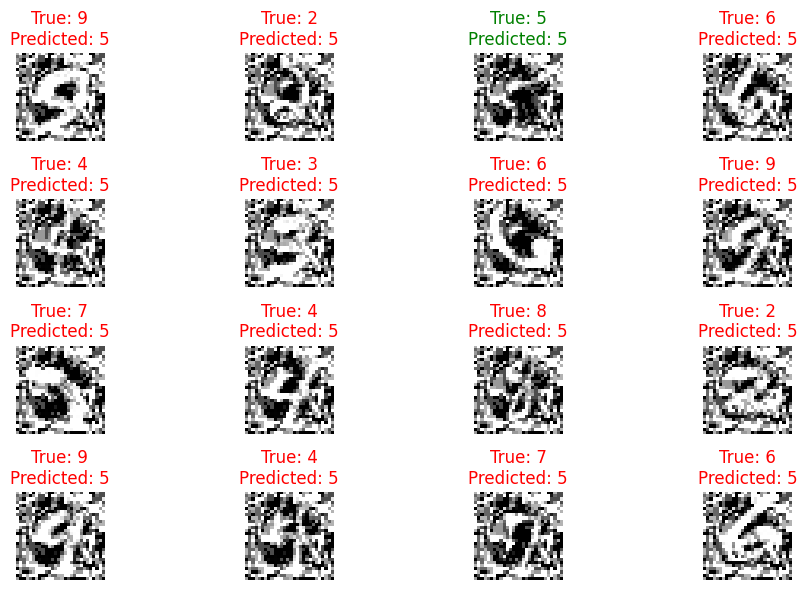

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]].reshape(28, 28), cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()